In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import json
import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from tree_segmentation.render import render_mesh

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-08 21:54:48.954671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 21:54:50.266550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-08-08 21:54:50.266772: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

2.0.1+cu117


In [3]:
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
cache_root = Path('~/wan_code/segmentation/tree_segmentation/results').expanduser()
utils.set_printoptions(linewidth=120)

In [4]:
data_root = Path('~/data/PartNet/data_v0').expanduser()
print(f"Data Root: {data_root}")
shapes = list(os.scandir(data_root))
print(f'There are {len(shapes)} shapes')

ShapeNet_root = Path('/data5/ShapeNet/ShapeNetCore.v2/')
print('ShapeNet root:', ShapeNet_root)

Data Root: /home/wan/data/PartNet/data_v0
There are 32537 shapes
ShapeNet root: /data5/ShapeNet/ShapeNetCore.v2


In [5]:
# example = data_root.joinpath('12136')
# example = data_root.joinpath('12012')
example = data_root.joinpath('7254')
# example = data_root.joinpath('22835')
# example = data_root.joinpath('27774')
print(f"Example dir", example)
with example.joinpath('meta.json').open('r') as f:
    meta = json.load(f)
print('meta:', meta)
# with example.joinpath('result_after_merging.json').open('r') as f:
#     meta_parts = json.load(f)
# print(list(os.scandir(example)))
# for item in os.scandir(example):
#     print('=' * 20, item.name, '=' * 20)
#     if item.name.endswith('.json'):
#         with example.joinpath(item.name).open('r') as f:
#             data = json.load(f)
#             print(yaml.dump(data))
mesh_path_shapenet = None
ShapeNet_shapes = []
for categroy in os.listdir(ShapeNet_root):
    if ShapeNet_root.joinpath(categroy, meta['model_id']).is_dir():
        mesh_path_shapenet = ShapeNet_root.joinpath(categroy, meta['model_id'])
        break
print(f"Find corresponding shape in ShapeNet:", mesh_path_shapenet)

Example dir /home/wan/data/PartNet/data_v0/7254
meta: {'model_id': '7cf2f3a1a3de48fda23949c21eddef76', 'anno_id': '7254', 'user_id': 'huangfuchong', 'time_in_sec': '257', 'version': '3', 'model_cat': 'Microwave'}
Find corresponding shape in ShapeNet: /data5/ShapeNet/ShapeNetCore.v2/03761084/7cf2f3a1a3de48fda23949c21eddef76


In [6]:
mesh = Mesh.load(mesh_path_shapenet.joinpath('models/model_normalized.obj'))
mesh.check()
mesh = mesh.unit_size().to(device)
# mesh.f_pos[:, -2:] = mesh.f_pos[:, -2:].flip(-1)
# mesh.f_tex[:, -2:] = mesh.f_tex[:, -2:]d.flip(-1)
# mesh.f_nrm[:, -2:] = mesh.f_nrm[:, -2:].flip(-1)
mesh.compuate_normals_(force=False)
f_pos = mesh.f_pos
f_nrm = mesh.f_nrm
f_tex = mesh.f_tex

image_size = 512
fovy = math.radians(90)
glctx = dr.RasterizeCudaContext()


In [7]:
num_views = 10
torch.manual_seed(42)
radius = torch.rand((num_views,), device=device) * 0.1 + 2.5
thetas = torch.arccos(torch.linspace(0, 1, num_views, device=device) * 2. - 1.)
phis = torch.linspace(0, 1, num_views, device=device) * 2.0 * torch.pi
# thetas = torch.tensor([90.], device=device).deg2rad_()
# phis = torch.ones((num,), device=device) * 0.5 * torch.pi
eye = ops_3d.coord_spherical_to(radius, thetas, phis).to(device)
Tw2v = ops_3d.look_at(eye, torch.zeros_like(eye))
Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size), device=device)
Tw2c = Tv2c @ Tw2v

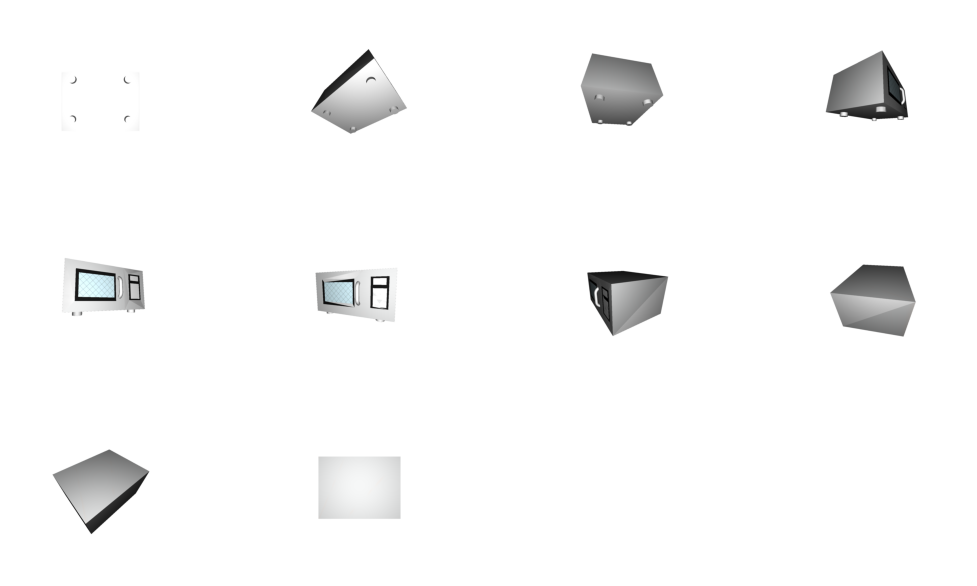

In [8]:
# mesh.compuate_normals_(force=True)
mesh.f_tex = f_tex.clone()
mesh.f_pos = f_pos.clone()
mesh.f_nrm = f_nrm.clone()
for index in [ 14766, 14767, 14771, 14773]:
    index= index -1
    # mesh.f_tex[index] = mesh.f_tex[index].flip(-1)
    mesh.f_pos[index] = mesh.f_pos[index].flip(-1)
    # mesh.f_nrm[index] = mesh.f_nrm[index].flip(-1)
mesh.compute_tangents_(force=True)
images, tri_ids = render_mesh(glctx, mesh, Tw2v, Tw2c, fovy)
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')

In [9]:
print(torch.unique(tri_ids[9]))

tensor([    0, 14766, 14767, 14771, 14773], device='cuda:0', dtype=torch.int32)


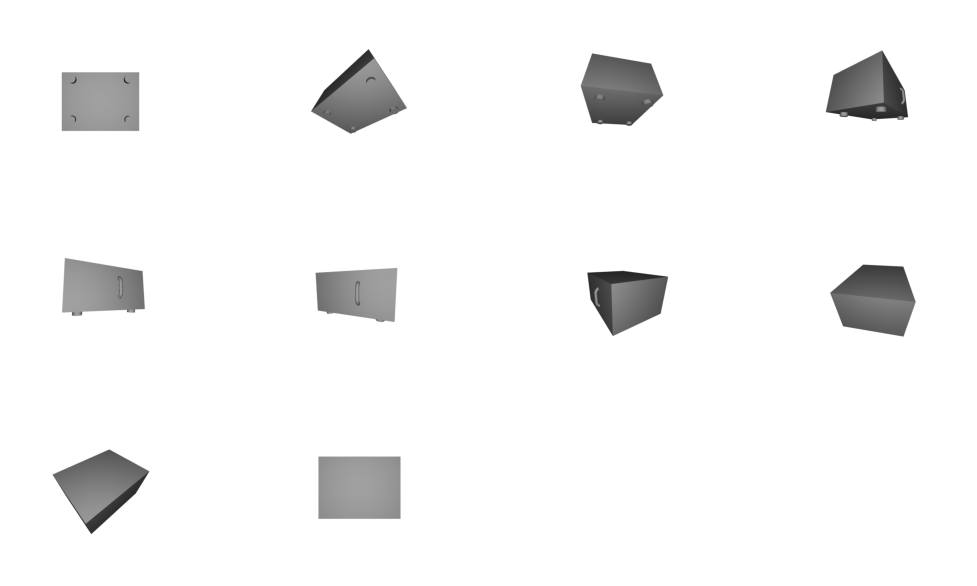

In [10]:
# mesh.compuate_normals_(force=True)
mesh = Mesh.load(mesh_path_shapenet.joinpath('models/model_normalized.obj'))
mesh.check()
mesh = mesh.unit_size().to(device)
mesh.f_pos[:, -2:] = mesh.f_pos[:, -2:].flip(-1)
mesh.f_tex[:, -2:] = mesh.f_tex[:, -2:].flip(-1)
mesh.f_nrm[:, -2:] = mesh.f_nrm[:, -2:].flip(-1)
mesh.compute_tangents_()
mesh.f_tex = None
images, tri_ids = render_mesh(glctx, mesh, Tw2v, Tw2c, fovy)
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')

In [11]:
mesh.f_tex = f_tex.clone()
mesh.f_pos = f_pos.clone()
mesh.f_nrm = f_nrm.clone()

v_pos = mesh.v_pos.float() if Tw2c is None else ops_3d.xfm(mesh.v_pos.float(), Tw2c)
v_pos = v_pos[None] if v_pos.ndim == 2 else v_pos
rast, _ = dr.rasterize(glctx, v_pos, mesh.f_pos.int(), (image_size, image_size))

unchanged = torch.ones(len(mesh.f_pos), dtype=torch.bool, device=device)
for i in range(num_views):
    f_indices = torch.unique(rast[i, :, :, -1].int())
    if f_indices[0] == 0:
        f_indices = f_indices[1:]
    f_indices = f_indices - 1
    f_indices = f_indices[unchanged[f_indices]]
    if len(f_indices) == 0:
        continue
    unchanged[f_indices] = 0
    v0, v1, v2 = v_pos[i, mesh.f_pos[f_indices], :3].unbind(1)
    face_normals = torch.cross(v1 - v0, v2 - v0)
    f_indices = f_indices[face_normals[:, -1] < 0]  # need change faces
    if len(f_indices) == 0:
        continue
    print(len(f_indices))
    mesh.f_pos[f_indices, :] = mesh.f_pos[f_indices, :].flip(-1)
    mesh.f_tex[f_indices, :] = mesh.f_tex[f_indices, :].flip(-1)
    mesh.f_nrm[f_indices, :] = mesh.f_nrm[f_indices, :].flip(-1)
    # mesh.f_tng[f_indices, :] = mesh.f_tng[f_indices, :].flip(-1)

217
49
20
260
125
111
87
3


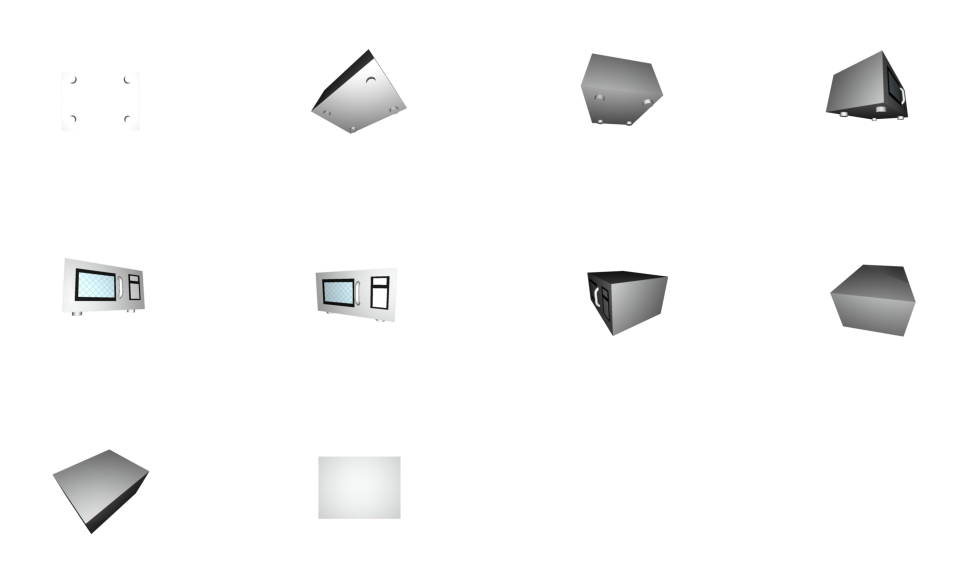

In [12]:
# mesh.compuate_normals_(force=True)
mesh.compute_tangents_(force=True)
images, tri_ids = render_mesh(glctx, mesh, Tw2v, Tw2c, fovy)
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')

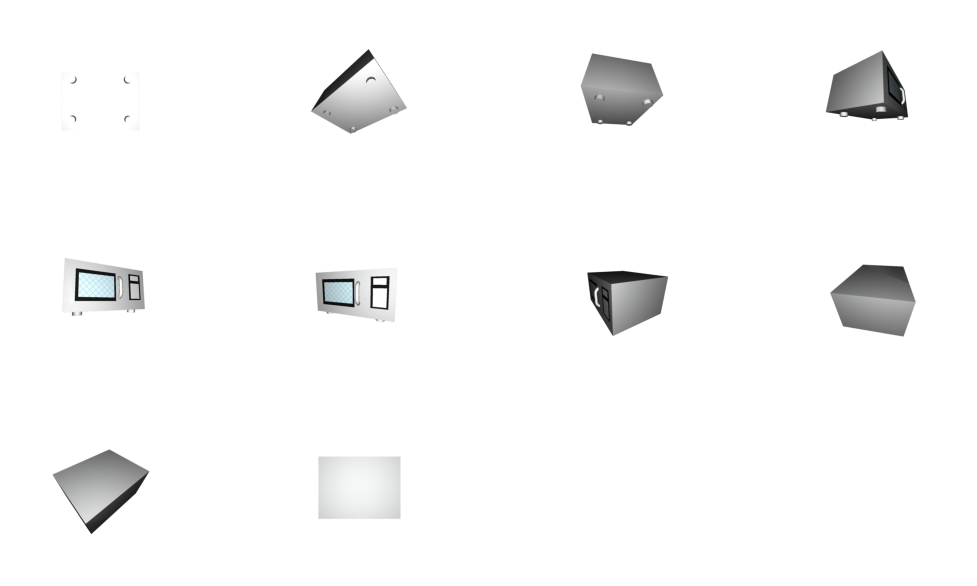

In [13]:
# mesh.compuate_normals_(force=True)
mesh.compute_tangents_(force=True)
images, tri_ids = render_mesh(glctx, mesh, Tw2v, Tw2c, fovy)
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')